# Explore  Simulated Muon Data  

We begin with a simplified Monte Carlo (MC) dataset containing muons simulated within the **PDHD detector**.
Familiarize yourself with the data format and event displays to develop an intuitive understanding of the dataset.

As you explore, consider the detector geometry and readout characteristics. Verify whether the observed data behavior aligns with the detector design and expected physical response. Also, note any indications of noise within the data.

🔍 Muons are used to calibrate the detector response because their tracks are long, clean, and well-understood. Muons also help characterize spallation backgrounds—when cosmic muons interact with argon and produce isotopes that mimic neutrino signals

📐 Precision Oscillation Measurements: DUNE compares the number and energy of muon neutrinos at the Near and Far Detectors to study neutrino oscillation.

In [2]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",] #visible signal  - trigger primitives 

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("../data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #MC carlo output 
tps  = load_data("../data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information  

- Only higher-energy cosmic muons can penetrate to DUNE, all the others are beam muons.

- Px, Py (where x is the drift direction) is roughly simmetrical: no preference between up and down of the PDHD

- This is not a boosted beam, it's isotropic in nature so the Pz momentum makes sense.

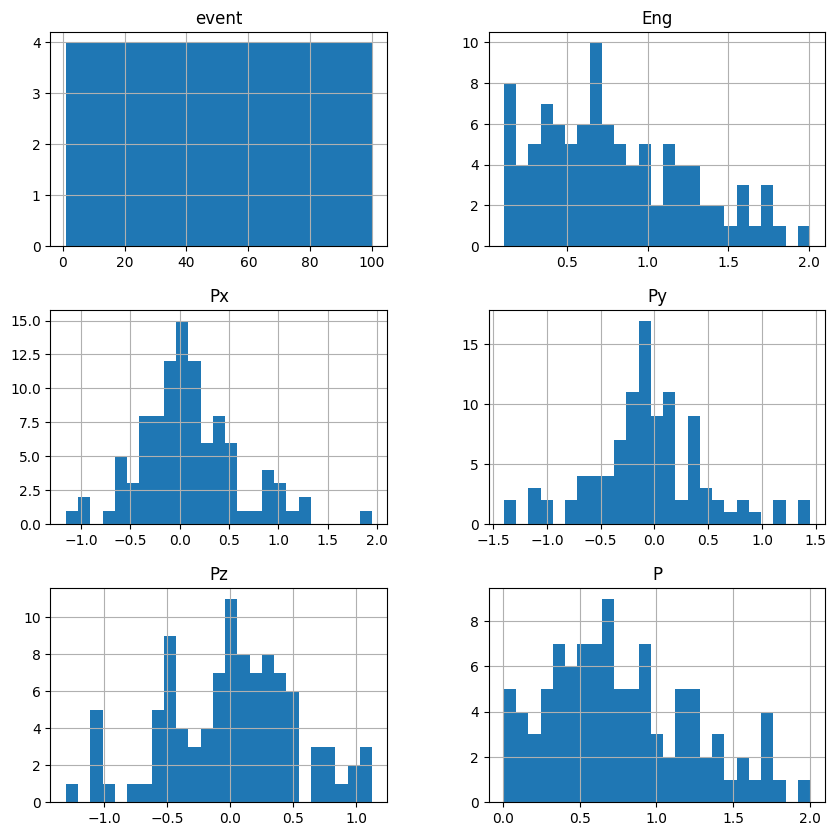

Eng mean: 0.79 and std deviation 0.46 GeV.
Px mean: 0.09 and std deviation 0.51 GeV.
Py mean: -0.05 and std deviation 0.53 GeV.
Pz mean: 0.01 and std deviation 0.53 GeV.


In [3]:
#MC data - note that the energies are in GeV
#Note: these are 100 events in 25 bins 
mc.hist(figsize= (10,10), bins =25)
plt.show()

print(f"Eng mean: {mc['Eng'].mean():.2f} and std deviation {mc['Eng'].std():.2f} GeV.")
print(f"Px mean: {mc['Px'].mean():.2f} and std deviation {mc['Px'].std():.2f} GeV.")
print(f"Py mean: {mc['Py'].mean():.2f} and std deviation {mc['Py'].std():.2f} GeV.")
print(f"Pz mean: {mc['Pz'].mean():.2f} and std deviation {mc['Pz'].std():.2f} GeV.")

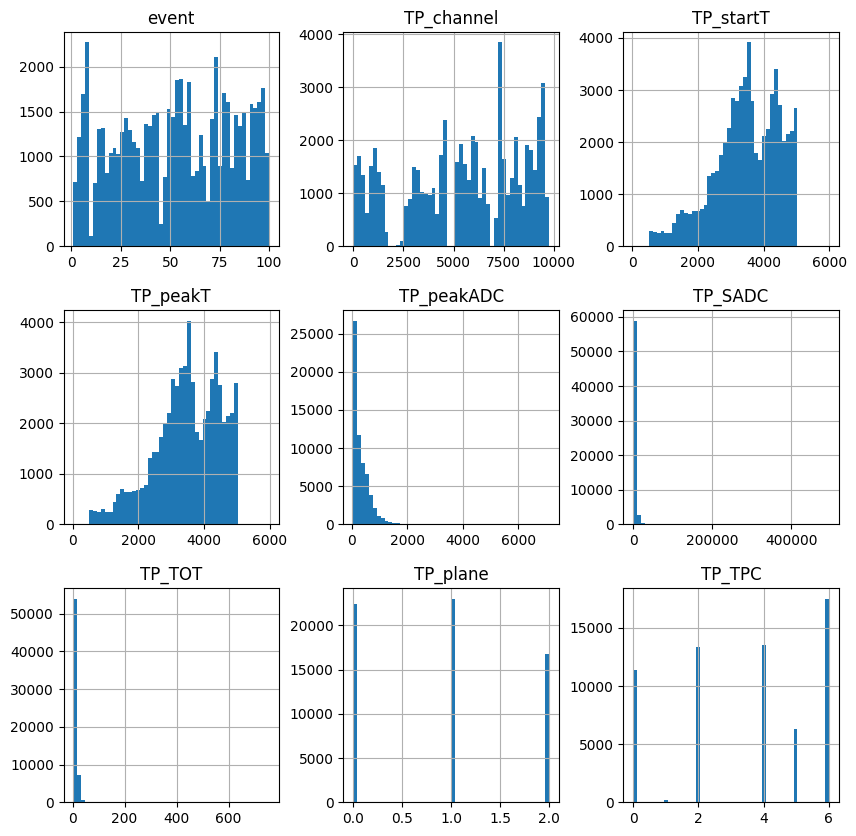

In [4]:
#TP data 
# Refers to the detector's response to simulated events
# This is the data you would "see" in the detector—i.e., the simulated output after the MC truth has passed through the detector simulation and signal processing.

#Collection plane: 960 vertical wires per side
#Induction planes: Two angled wire planes with 800 wires each, wrapping around both sides

tps[tps.TP_TOT>2].hist(figsize= (10,10), bins =50)
plt.show()

More energy deposited by a particle → more ionization electrons → larger integrated signal (higher SADC).
There are calibration steps to convert SADC to true energy, but for summary and comparison, SADC is a good proxy for deposited energy.


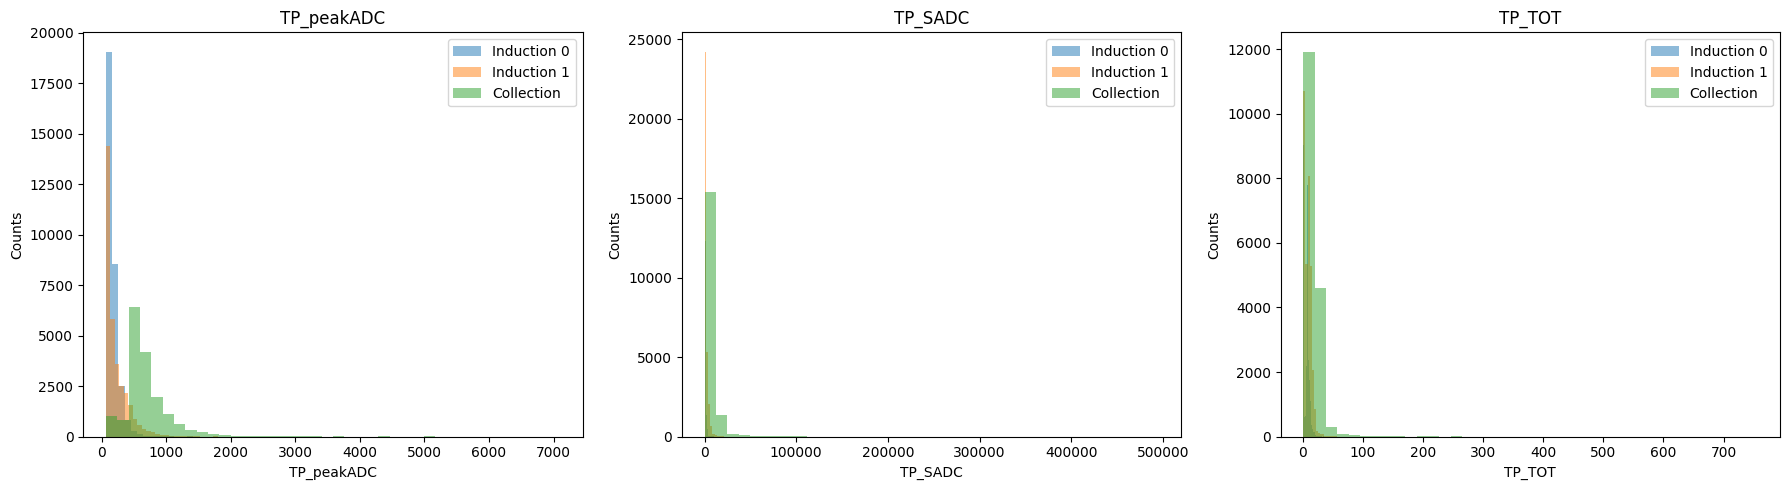

In [5]:
# Plot histograms of TP properties for each plane
plane_labels = {0: "Induction 0", 1: "Induction 1", 2: "Collection"}
properties = ["TP_peakADC", "TP_SADC", "TP_TOT"]

fig, axs = plt.subplots(1, len(properties), figsize=(18, 5))
for i, prop in enumerate(properties):
    for plane in [0, 1, 2]:
        data = tps[tps.TP_plane == plane][prop]
        axs[i].hist(data, bins=40, alpha=0.5, label=plane_labels[plane])
    axs[i].set_title(prop)
    axs[i].set_xlabel(prop)
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.tight_layout()
plt.show()

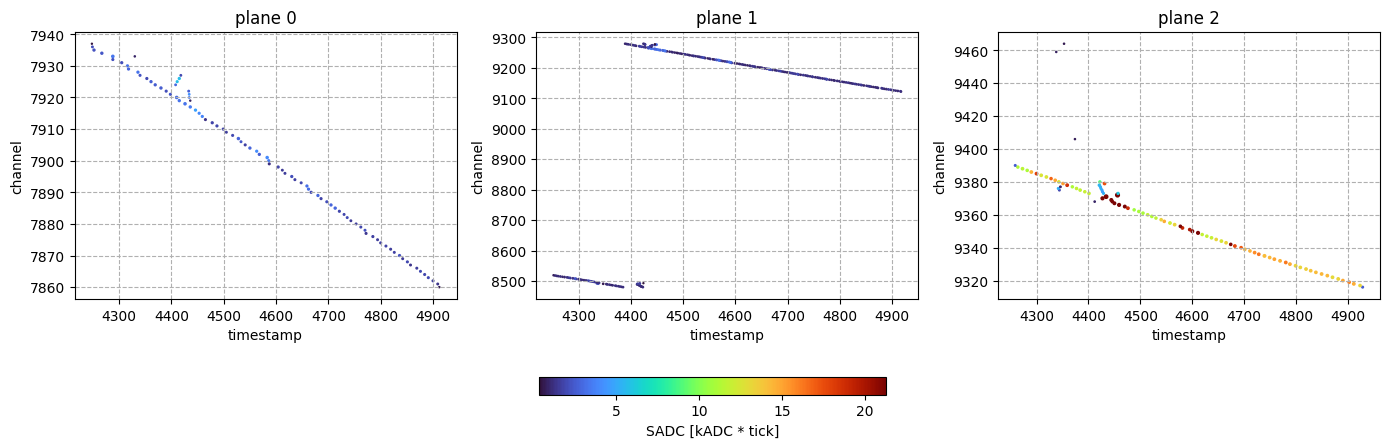

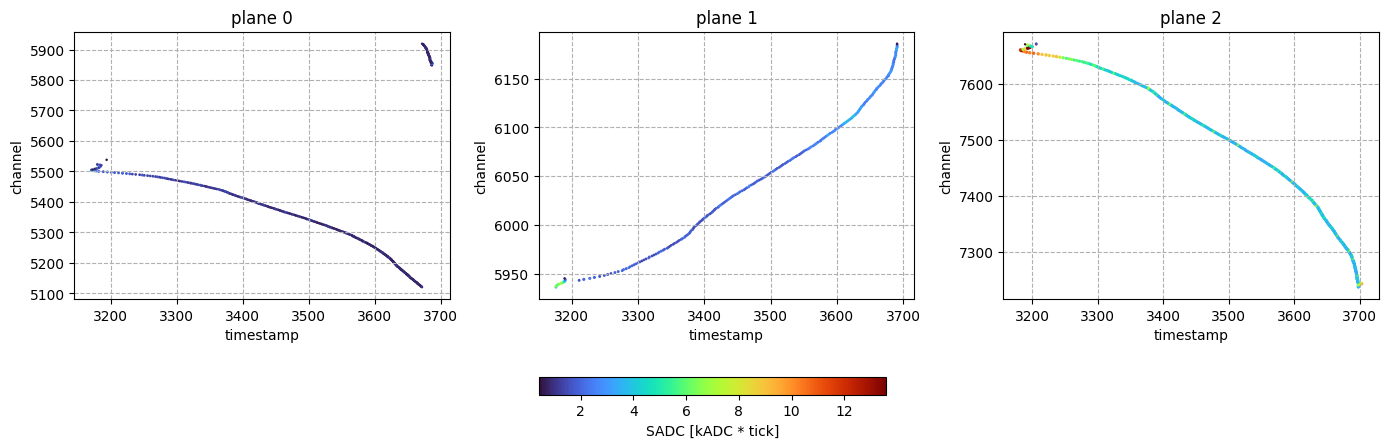

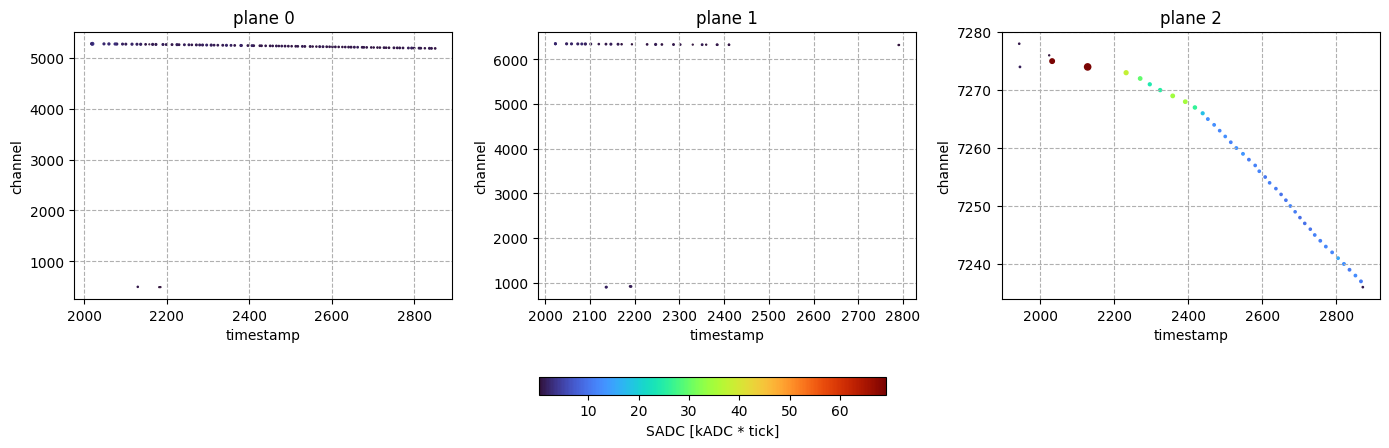

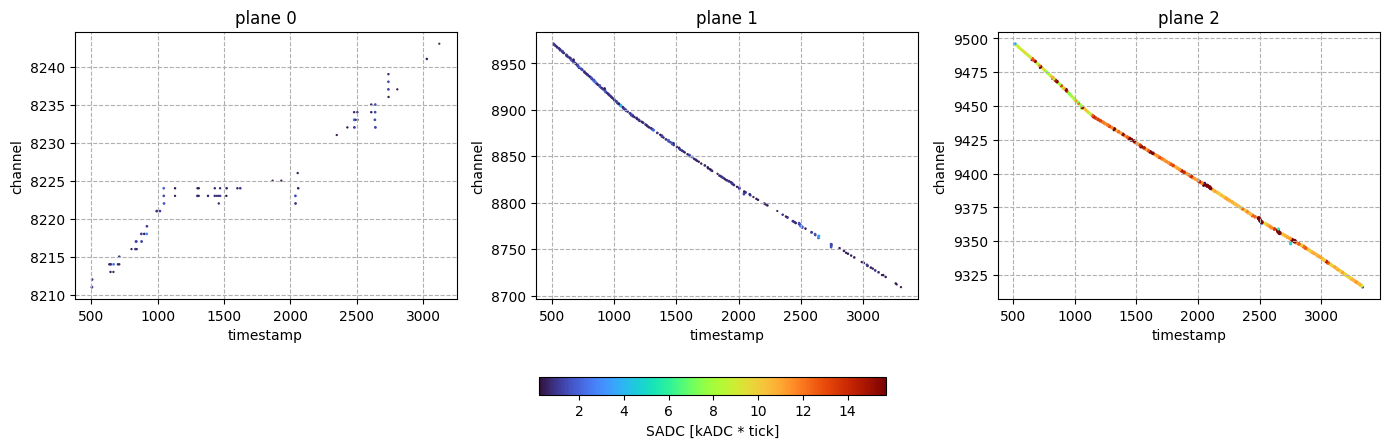

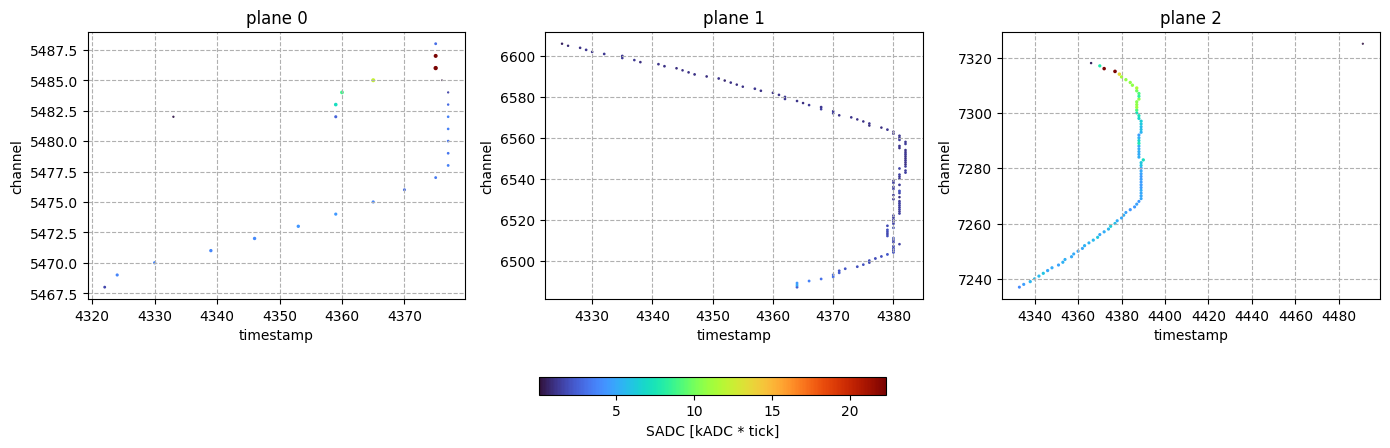

In [6]:
def PlotData(df, event, hit_threshold = 80):
    '''
    A function that let's you plot the trajectory of the muon in time-channel space, as seen within the detector
    increase the hit finding threshold if you're seeing noise in the data

    This cell provides a graphical “event display” for a chosen event, letting you examine the spatial and temporal structure of particle tracks as recorded by the detecto
    '''

    tps_all = df[(df.event == event)  & (df.TP_peakADC > hit_threshold)]
    vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

    fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

    for plane in range(3):
        tps = tps_all[tps_all.TP_plane == plane]
        sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
        ax[plane].set_xlabel("timestamp")
        ax[plane].set_ylabel("channel")
        ax[plane].set_title(f"plane {plane}")
        ax[plane].grid(linestyle='dashed')

    fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
    plt.tight_layout()
    plt.show()

PlotData(tps, 92)
PlotData(tps, 91)
PlotData(tps,90)
PlotData(tps, 80, hit_threshold=80)   #side effect of the induction plane, where the signal is a dual phase signal
PlotData(tps,60)#it's because probably there is an electron, candidate muon for decay

- You can clearly see that each track almost looks like it has one single color on the induction planes. It makes sense that the SADC is higher on the collector plane.

- It also makes sense that the trajectory is about linear and goes through the channels of nearby APAs
    Cosmic muon ray do not stop for any reason, while candidate muon have a straight line and a final curvature are a muon decaying into electron (look at event 60)

- You can clearly see that there are some kind of discretization noises in the event 80. This is just because of the dual phase of the waveforms and how their slightly cancelling each other in the y plane

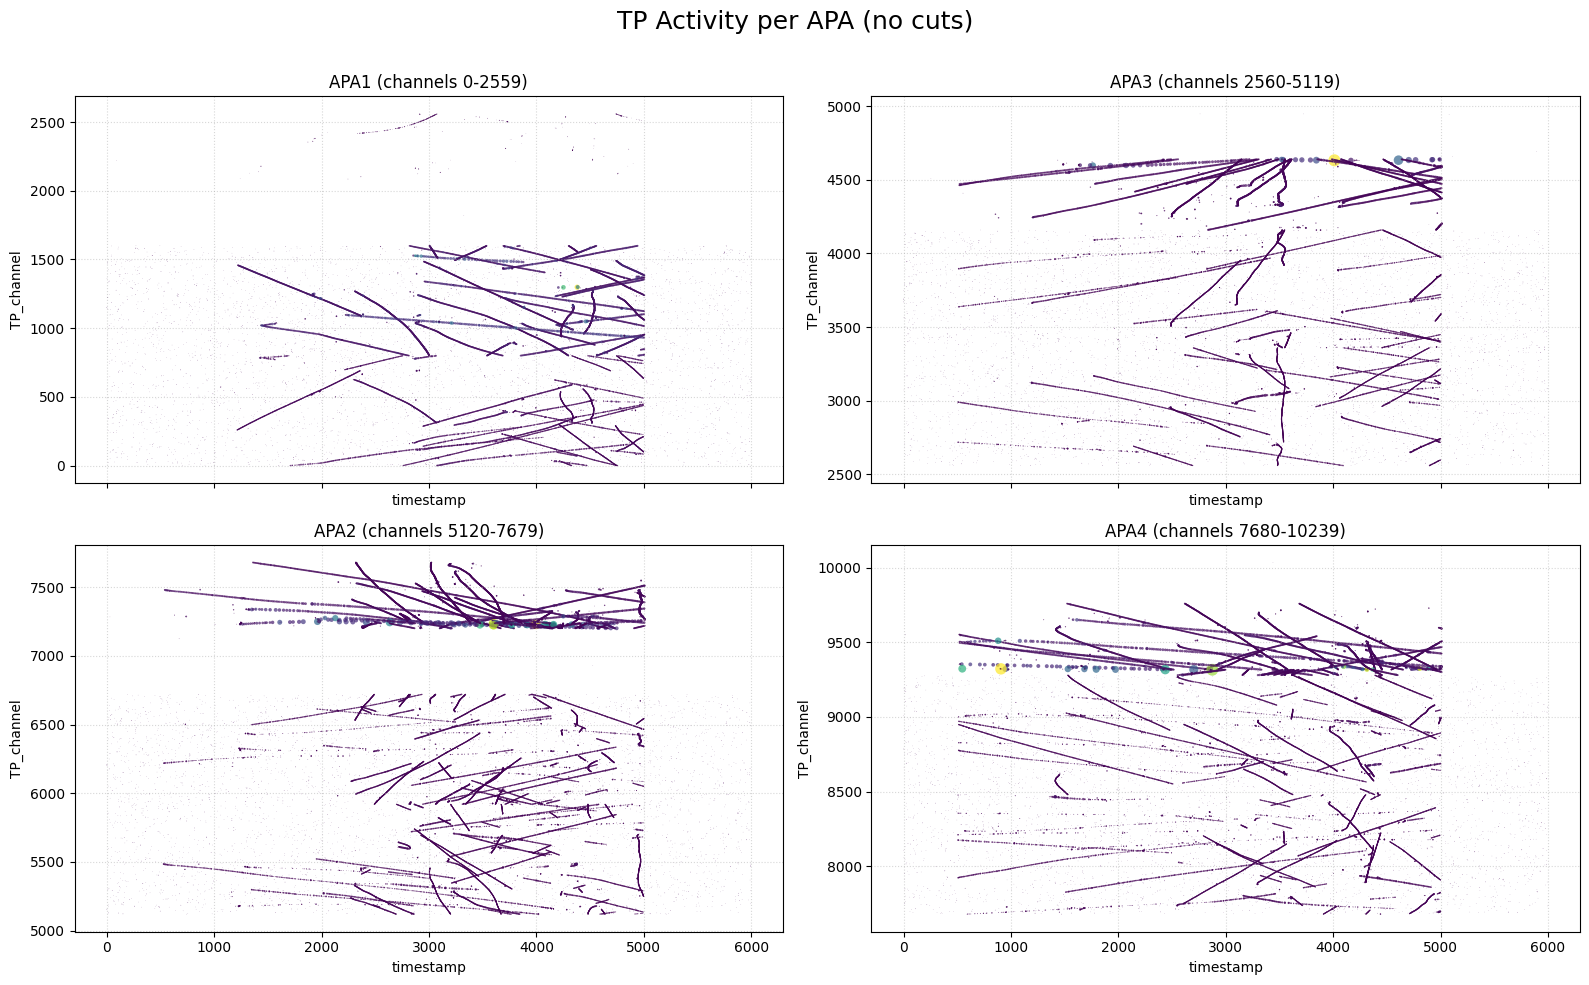

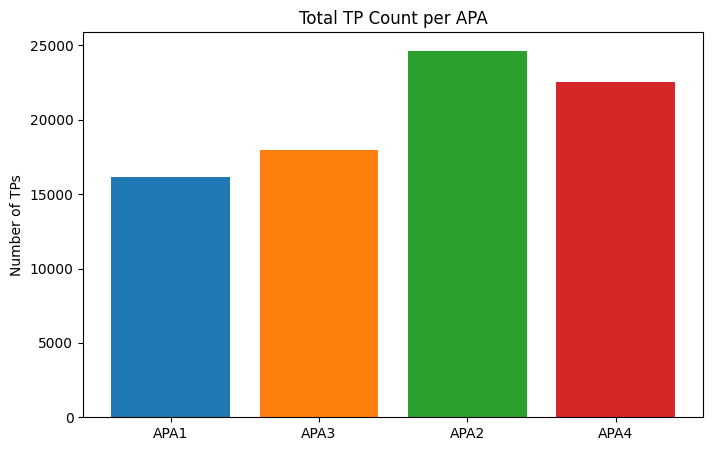

In [36]:
def plot_plane_traces(tps):
    """
    Visualizes TP activity for each APA based on TP_channel.
    APA mapping:
        APA1: channels 0–2559
        APA3: channels 2560–5119
        APA2: channels 5120–7679
        APA4: channels 7680–10239
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    # --- Scatter plot: channel vs. TP_peakT for each APA ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for (i, (apa, (start, stop))) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel, 
            s=df_apa.TP_TOT/10, 
            c=df_apa.TP_SADC/1e3, 
            cmap="viridis", 
            alpha=0.7,
            edgecolor="none"
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)
    plt.suptitle("TP Activity per APA (no cuts)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- Bar plot: TP count per APA ---
    apa_counts = [
        len(tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]) 
        for (start, stop) in apa_ranges.values()
    ]
    plt.figure(figsize=(8, 5))
    plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
    plt.ylabel("Number of TPs")
    plt.title("Total TP Count per APA")
    plt.show()

plot_plane_traces(tps)

In the above picture you can see some noise (those thin straight lines), and almost everything in the same color.

Plotting for threshold: 100 (TPs remaining: 66204, percentage: 81.34%)


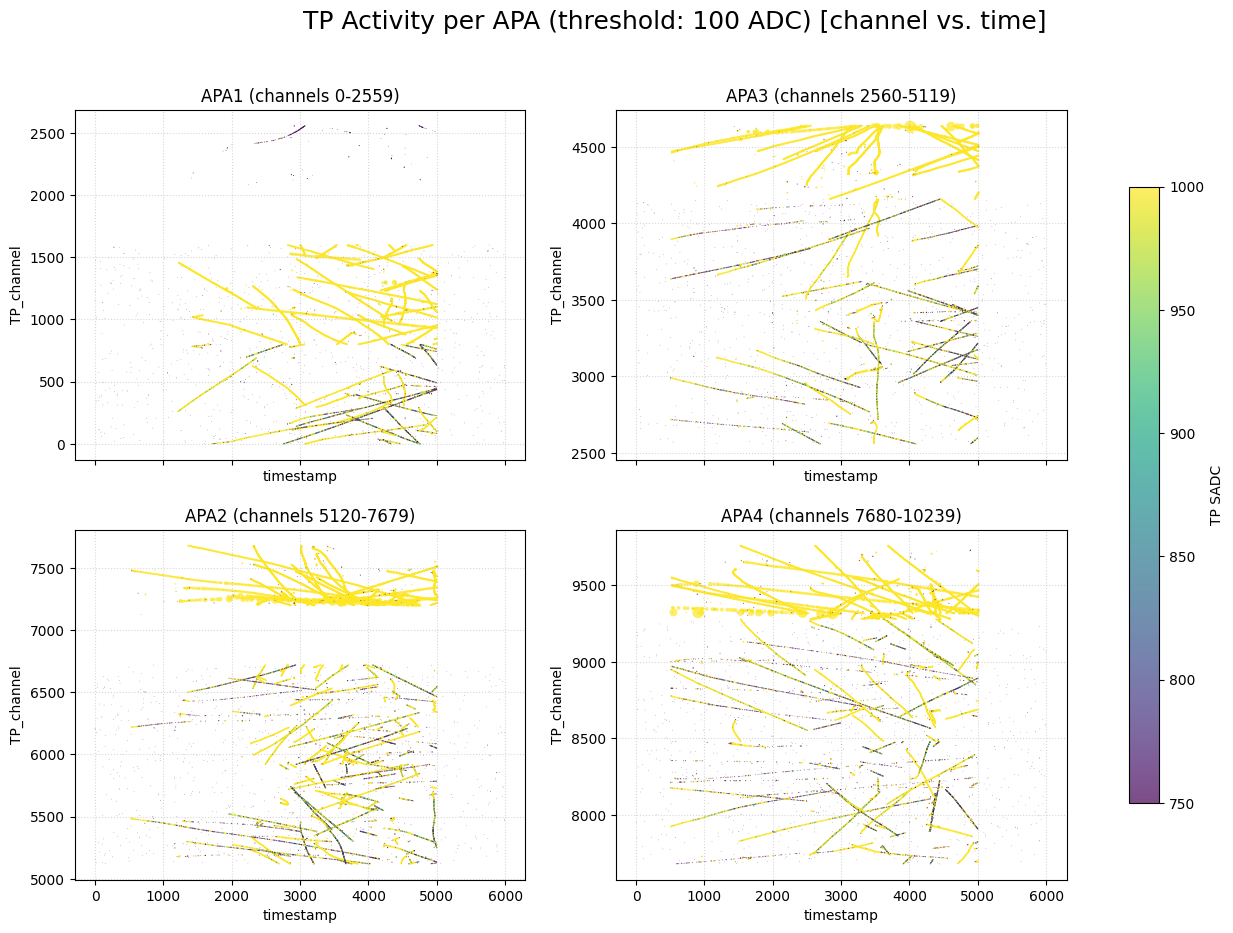

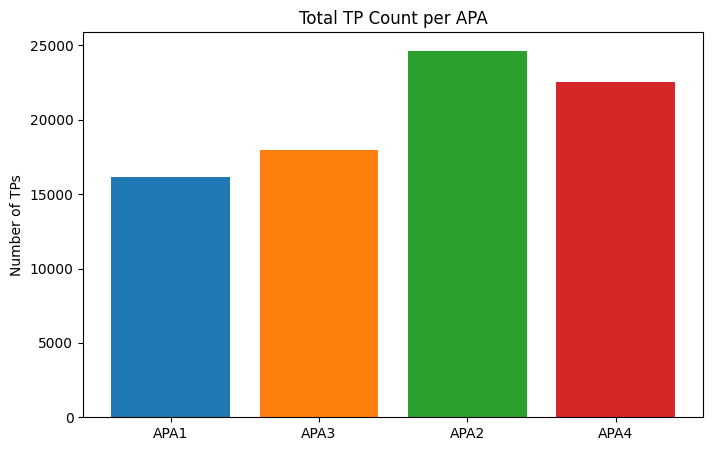

Plotting for threshold: 180 (TPs remaining: 62230, percentage: 76.46%)


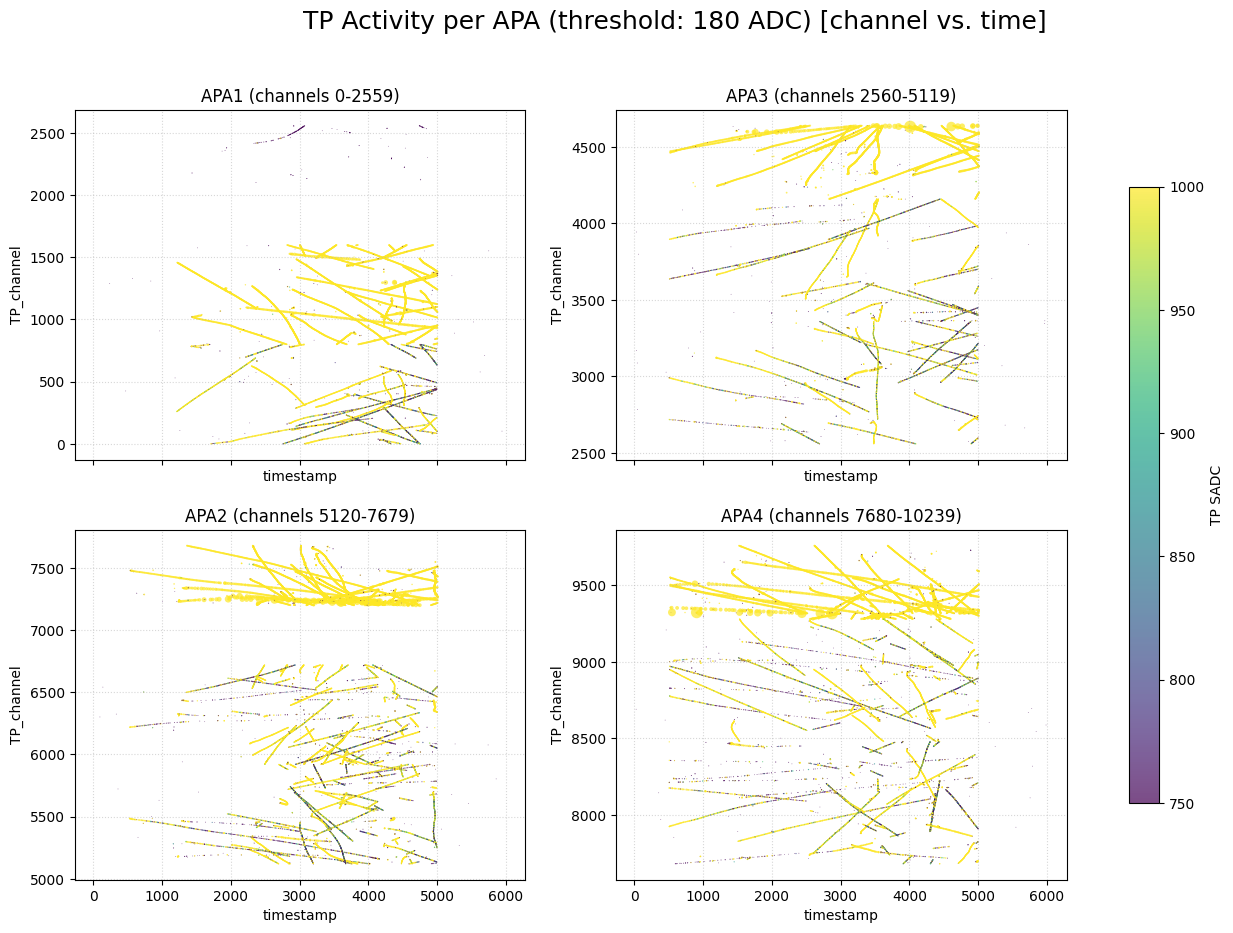

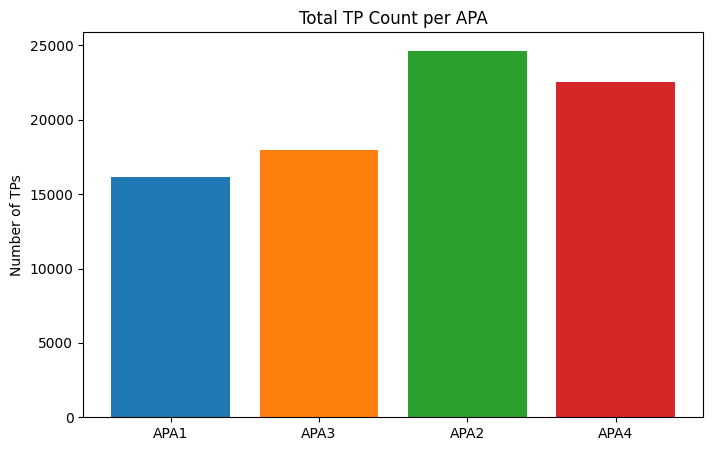

Plotting for threshold: 280 (TPs remaining: 60660, percentage: 74.53%)


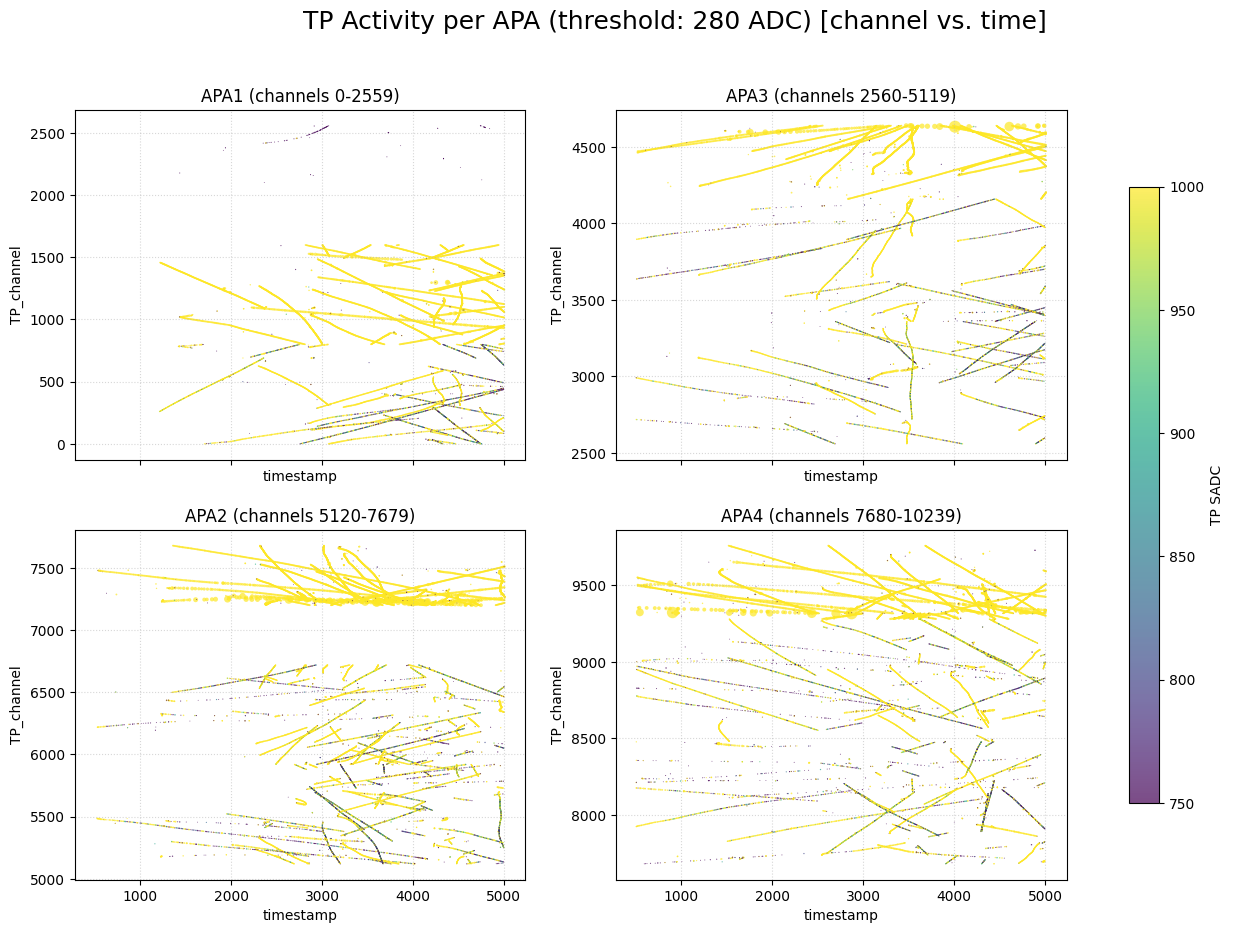

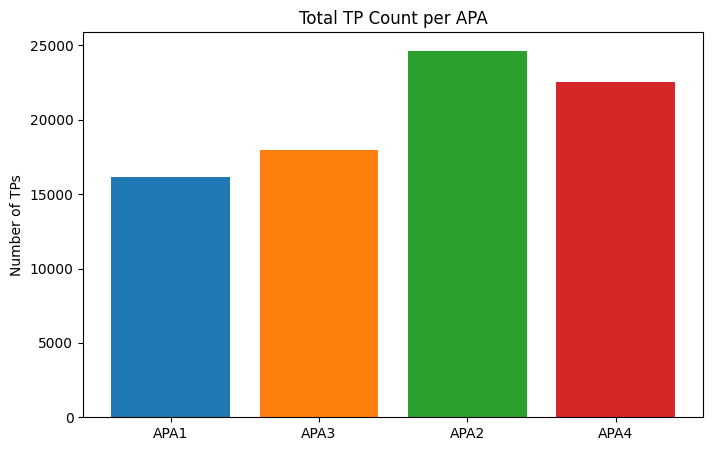

In [31]:
def plot_plane_traces_thresholds(tps, thresholds, vmin, vmax):
    """
    Visualizes TP activity for each APA at different SADC thresholds.
    Uses a perceptually uniform colormap for better low-energy contrast.
    Produces one set of plots per threshold.
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }

    for thresh in thresholds:
        filtered = tps[tps.TP_SADC > thresh]
        print(f"Plotting for threshold: {thresh} (TPs remaining: {len(filtered)}, percentage: {len(filtered)/len(tps)*100:.2f}%)")
        
        # --- Scatter plot: channel vs. TP_peakT for each APA ---
        fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
        for (i, (apa, (start, stop))) in enumerate(apa_ranges.items()):
            ax = axs[i//2][i%2]
            df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
            sc = ax.scatter(
                df_apa.TP_peakT, df_apa.TP_channel,
                s=df_apa.TP_TOT/10,
                c=df_apa.TP_SADC,
                cmap="viridis",
                alpha=0.7,
                edgecolor="none",
                vmin=vmin,
                vmax=vmax
            )
            ax.set_title(f"{apa} (channels {start}-{stop-1})")
            ax.set_xlabel("timestamp")
            ax.set_ylabel("TP_channel")
            ax.grid(True, linestyle="dotted", alpha=0.5)
        plt.suptitle(f"TP Activity per APA (threshold: {thresh} ADC) [channel vs. time]", fontsize=18)
        cbar = fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
        plt.show()
        
        # --- Bar plot: TP count per APA ---
        apa_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
        apa_counts = [
            len(tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]) 
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
        plt.ylabel("Number of TPs")
        plt.title("Total TP Count per APA")
        plt.show()

# Usage:
plot_plane_traces_thresholds(tps, thresholds=[100, 180, 280],vmin=750, vmax=1000)


- It's clear that most of the tracks are above 480 SADC. The relative loss in TPs decreases extremely after thr=280, so it doesn't make any sense to go above that threshold, unless you want to concentrate on the VHE muons (probably in the center of the beam).

- If the track is uniform in color, you have a constant deposit. → If it varies along the track, it could indicate progressive energy loss (e.g. muon stopping) or angular variation.

- Are these big and bright yellow dots any vertex decay?

- APA2 seems to be the noisest for some reason


In [47]:
def find_optimal_tp_threshold(tps, min_thresh, max_thresh, step, delta_percent=2.0):
    """
    Finds the optimal TP_SADC threshold such that the relative decrease in TPs becomes negligible.
    Returns the first threshold for which the percent of lost TPs in the selection to respect to the previous threshold is < delta_percent.
    """
    total = len(tps)
    prev_percent = 0
    thresholds = np.arange(min_thresh, max_thresh+step, step) # the max_thresh+step is just because otherwise the last threshold would not be included in the comparison
    for thresh in thresholds:
        filtered_count = (tps.TP_SADC > thresh).sum()
        percent_lost = 100 * (total - filtered_count) / total
        percent_diff = percent_lost - prev_percent
        print(f"Thresh: {thresh:4d} | Lost: {percent_lost:6.2f}% | Delta: {percent_diff:6.2f}%")
        if thresh > min_thresh and abs(percent_diff) < delta_percent:
            return prev_thresh, prev_percent
        prev_percent = percent_lost
        prev_thresh = thresh
    return thresholds[-1], 100 * (total - (tps.TP_SADC > thresholds[-1]).sum())/total

optimal_thresh, percent = find_optimal_tp_threshold(tps, min_thresh=50, max_thresh=500, step=50)
print(f"Optimal threshold: {optimal_thresh} (percent lost: {percent:.2f}%)")

Thresh:   50 | Lost:   0.00% | Delta:   0.00%
Thresh:  100 | Lost:  18.66% | Delta:  18.66%
Thresh:  150 | Lost:  23.50% | Delta:   4.84%
Thresh:  200 | Lost:  24.20% | Delta:   0.70%
Optimal threshold: 150 (percent lost: 23.50%)


### Examine how Trigger Primitive (TP) properties vary between events and consider possible reasons.

Right now the only idea I got to classify based on direction is to see if they are either straight or not based on a linear fit, but I am unable to do it without using some sort of the projection of the data in 3D, with stitching and recognition of the triplets. 

I would try then to choose the correct RMS to binary classify it either "straight" or "curved" line.

In [58]:
def plot_tp_properties_by_energy(df, energy_min=400, energy_max=1000, 
                                 threshold=0, collection_plane=2, bins=30):
    """
    Plot bar histograms of TP properties for collection plane, binned by energy.

    - energy_min, energy_max: range of energies to consider (on TP_SADC)
    - threshold: minimum TP_peakADC to consider 
    - bins: number of energy bins
    """
    # Filter to collection plane, threshold, and energy range
    mask = (
        (df["TP_plane"] == collection_plane) &
        (df['TP_peakADC'] > threshold) &
        (df["TP_SADC"] >= energy_min) &
        (df["TP_SADC"] <= energy_max)
    )
    df_filt = df[mask].copy()
    
    if df_filt.empty:
        print("No data after filtering. Check thresholds and input DataFrame.")
        return

    # Select properties: 
    # Remove meta and channel, but include time_over_threshold (TP_TOT)
    ignore_cols = {"TP_SADC", "TP_plane", "event", "TP_channel", "TP_TPC"}
    tp_properties = [col for col in df_filt.columns 
                     if (col not in ignore_cols and np.issubdtype(df_filt[col].dtype, np.number))]

    # Force time_over_threshold (TP_TOT) to be present even if not automatically found
    if "TP_TOT" not in tp_properties and "TP_TOT" in df_filt.columns:
        tp_properties.append("TP_TOT")

    # Bin by energy
    df_filt['energy_bin'] = pd.cut(df_filt["TP_SADC"], bins=bins)
    # Get the bin centers as labels
    bin_centers = df_filt['energy_bin'].apply(lambda x: (x.left + x.right) / 2)
    df_filt['energy_bin_center'] = bin_centers

    # For each property, plot one figure
    for prop in tp_properties:
        # Group by energy_bin_center
        grouped = df_filt.groupby('energy_bin_center')[prop]
        means = grouped.mean()
        stds = grouped.std()
        centers = means.index.values

        plt.figure(figsize=(7,5))
        plt.errorbar(
    centers,            # x: bin centers
    means,              # y: mean property value for each bin
    xerr=(energy_max-energy_min)/bins*0.8,   # x error: half the bin width
    yerr=stds,          # y error: standard deviation for each bin
    fmt='.',           
    capsize=2,          
    color='blue',       # marker and error bar color
    ecolor='black',     # error bar color
    elinewidth=1,       # error bar line width
    markersize=6        # marker size
)
        plt.title(f"{prop} vs Energy")
        plt.xlabel("Energy (ADC)")
        plt.ylabel(prop)
        plt.xticks(centers, [f"{c:.0f}" for c in centers], rotation=45)
        plt.tight_layout()
        plt.show()

Plotting TP properties by energy with no cuts.


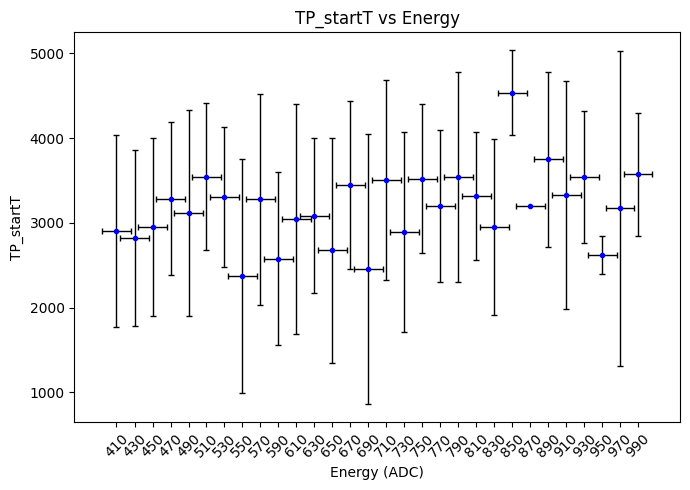

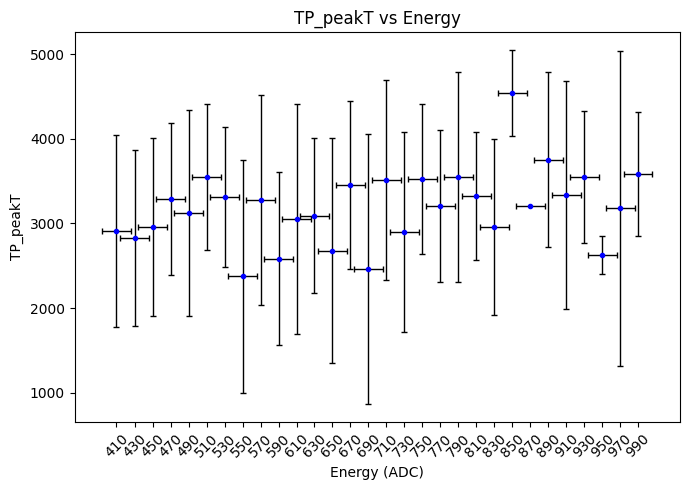

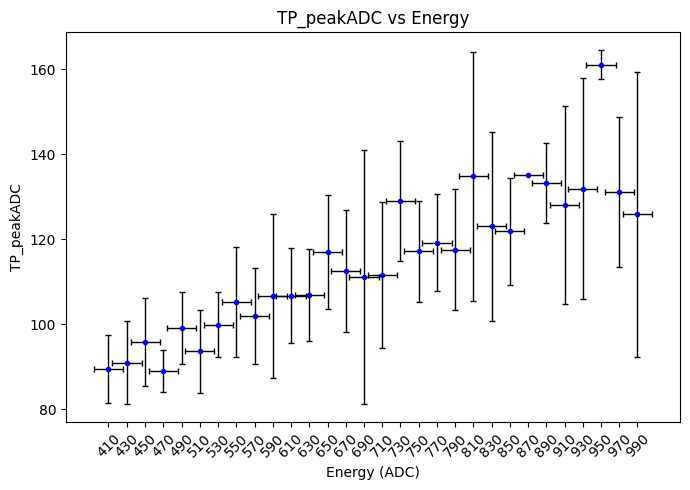

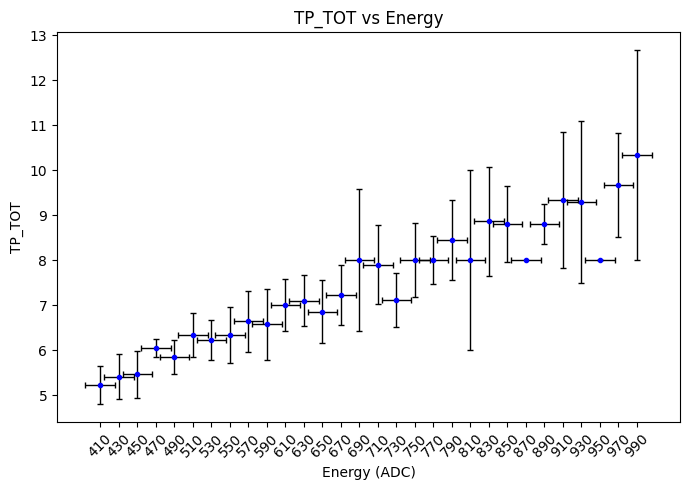

In [62]:
print("Plotting TP properties by energy with no cuts.")
plot_tp_properties_by_energy(tps)

In [67]:
def plot_tp_properties_by_energy(
    df, 
    collection_plane=2, 
    bins=30, properties=None):
    """
    Overlay mean+std plots for TP properties in the collection plane, for multiple energy/cut configurations.
    cuts: list of dicts, each with keys: energy_min, energy_max, threshold, label
    """
    cuts = [
            dict(energy_min=400, energy_max=1000, threshold=0, label="No cuts"),
            dict(energy_min=750, energy_max=1000, threshold=0, label="Energy 750-1000 ADC"),
            dict(energy_min=400, energy_max=1000, threshold=100, label="Peak > 100")
    ]
    
    colors = ['blue', 'orange', 'green', 'magenta', 'red', 'cyan']
    markers = ['o', 's', '^', 'v', 'D', 'x']

    # Determine which properties to plot
    ignore_cols = {"TP_SADC", "TP_plane", "event", "TP_channel", "TP_TPC"}
    if properties is None:
        properties = [col for col in df.columns 
                      if (col not in ignore_cols and np.issubdtype(df[col].dtype, np.number))]
    if "TP_TOT" not in properties and "TP_TOT" in df.columns:
        properties.append("TP_TOT")

    # One plot per property, overlaying cuts
    for prop in properties:
        plt.figure(figsize=(8,5))
        for i, cut in enumerate(cuts):
            mask = (
                (df["TP_plane"] == collection_plane) &
                (df['TP_peakADC'] > cut.get('threshold',0)) &
                (df["TP_SADC"] >= cut.get('energy_min',400)) &
                (df["TP_SADC"] <= cut.get('energy_max',1000))
            )
            df_filt = df[mask].copy()
            if df_filt.empty:
                continue
            df_filt['energy_bin'] = pd.cut(df_filt["TP_SADC"], bins=bins)
            bin_centers = df_filt['energy_bin'].apply(lambda x: (x.left + x.right) / 2)
            df_filt['energy_bin_center'] = bin_centers
            energy_bin_width = (cut.get('energy_max',1000) - cut.get('energy_min',400)) / bins

            grouped = df_filt.groupby('energy_bin_center')[prop]
            means = grouped.mean()
            stds = grouped.std()
            centers = means.index.values
            counts = grouped.count()

            plt.errorbar(
                centers, means, 
                xerr=energy_bin_width/2, 
                yerr=stds, 
                fmt=markers[i%len(markers)], 
                capsize=2, 
                color=colors[i%len(colors)], 
                ecolor=colors[i%len(colors)], 
                elinewidth=1, 
                markersize=4,
                label=f"{cut['label']} (n={int(counts.sum())})"
            )
        plt.title(f"{prop} vs Energy (Collection plane)")
        plt.xlabel("Energy (ADC)")
        plt.ylabel(prop)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

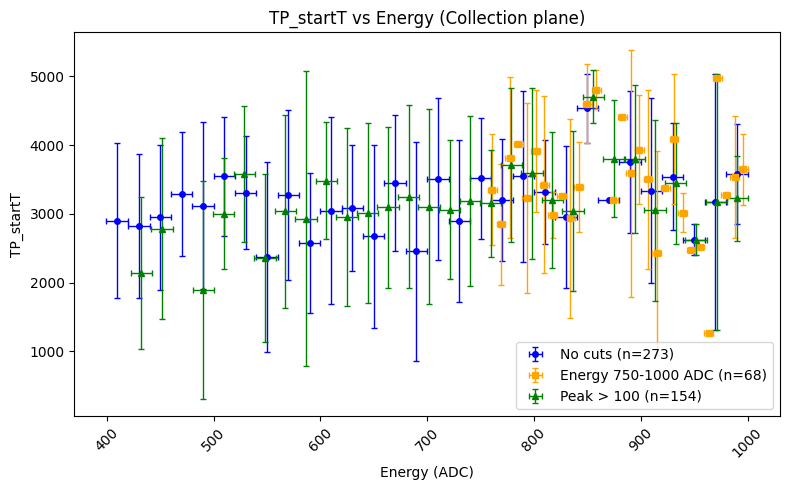

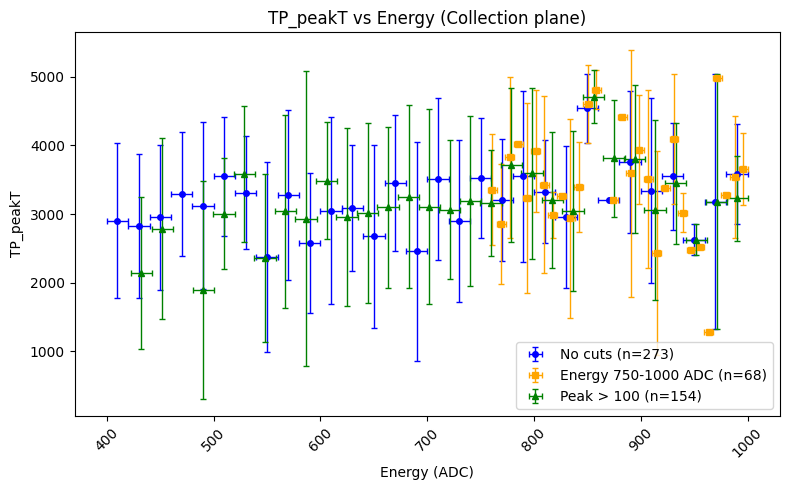

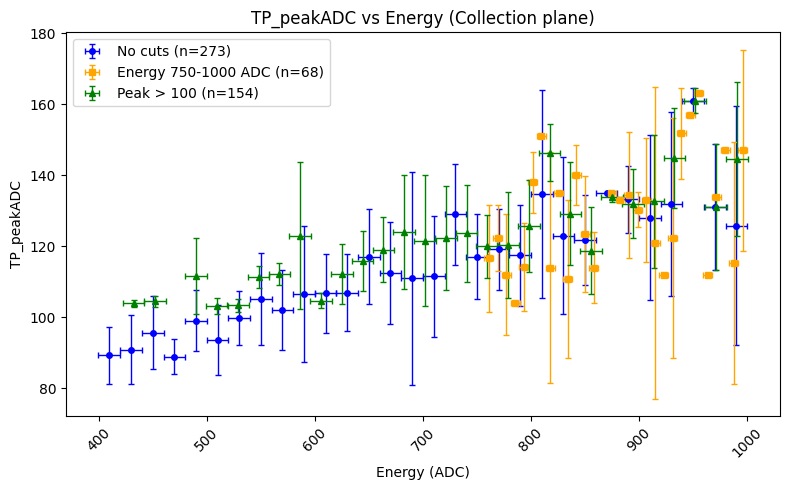

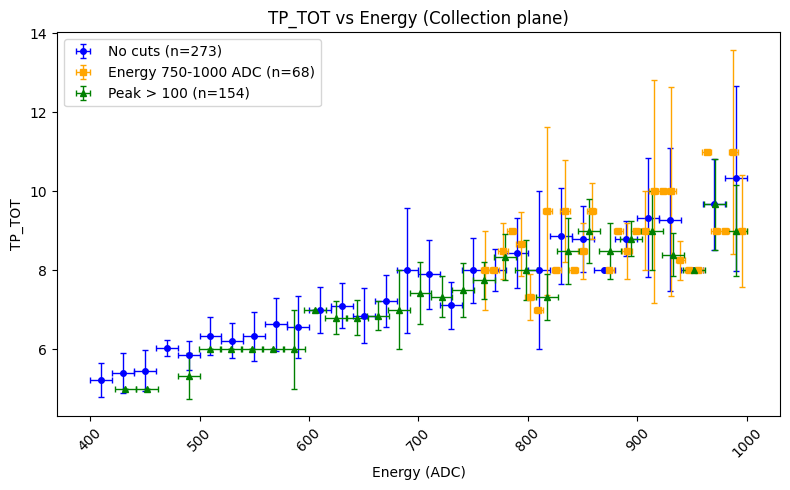

In [68]:
plot_tp_properties_by_energy(tps)

### Correlating Muon Energy with TP Activity  

One useful direction is to study how the energy of the muon correlates with the total visible energy recorded by the TPs, particularly in the **collection plane (plane 2)**, which is often the most signal-rich. Here's a step-by-step  example of how you can process the data and make associations between the TP and MC information based on event ID: 

Try the code below and see if it makes sense to you! Does the plot look like you would expect it to? Can you compare the visible energy in the other planes? 

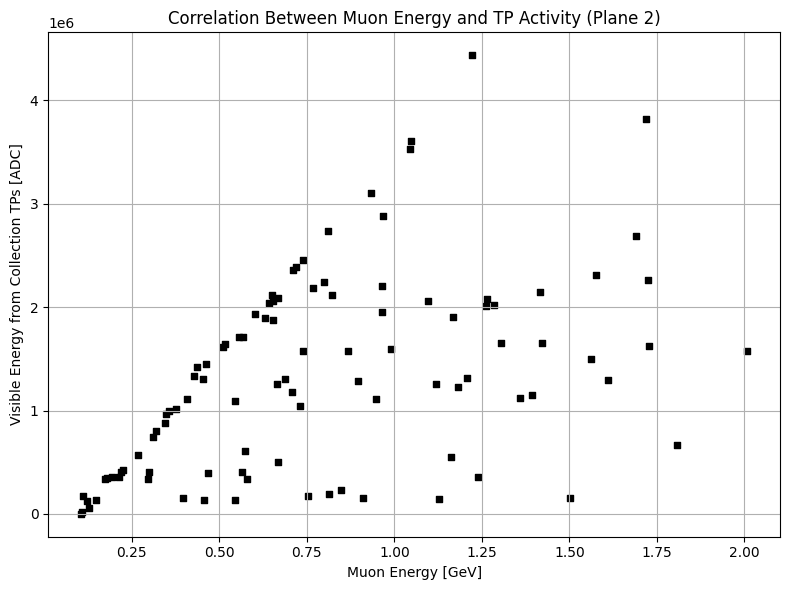

In [49]:
# Select only Trigger Primitives from the collection plane (plane ID == 2)
tp_plane2 = tps[tps.TP_plane == 2]

# Identify unique event IDs that have activity in plane 2
# (This helps exclude events where the muon left the detector without passing through the active volume - hence producing no visible energy)
events_with_tp_activity = tp_plane2['event'].unique()

# From the MC dataset, select only those events that had visible TP activity and extract the corresponding muon energy values
muon_energy = mc[mc['event'].isin(events_with_tp_activity)].set_index('event')['Eng']

# Sum up the energy from all the collection TPs for each event 
visible_energy = tp_plane2.groupby('event')['TP_SADC'].sum() 

# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(muon_energy, visible_energy, s=20, c='k', marker='s')
plt.xlabel("Muon Energy [GeV]")
plt.ylabel("Visible Energy from Collection TPs [ADC]")
plt.title("Correlation Between Muon Energy and TP Activity (Plane 2)")
plt.grid(True)
plt.tight_layout()
plt.show()